# 🚀 RAG with OpenSearch & LlamaIndex

This notebook demonstrates **Retrieval-Augmented Generation (RAG)** using:
- **Docling** for intelligent document processing and chunking
- **LlamaIndex** as the RAG framework
- **OpenSearch** as the vector database
- **IBM Granite Embedding** for embeddings (local)
- **Ollama with IBM Granite** for LLM generation (local)

---

## 🎯 Bird's Eye View: RAG Pipeline Architecture

```mermaid
%%{init: {'theme':'base', 'themeVariables': { 'primaryColor':'#ff6b6b','primaryTextColor':'#fff','primaryBorderColor':'#c92a2a','lineColor':'#fab005','secondaryColor':'#4c6ef5','tertiaryColor':'#51cf66','background':'#f8f9fa','mainBkg':'#e7f5ff','secondaryBkg':'#fff5f5','tertiaryBkg':'#d3f9d8'}}}%%
flowchart TB
    subgraph Input["📄 INPUT STAGE"]
        A1[PDF/DOCX Documents]
        A2[User Query]
    end
    
    subgraph Processing["🔧 DOCUMENT PROCESSING"]
        B1["📋 DoclingReader<br/>(Parse PDF)"]
        B2["✂️ HybridChunker<br/>(Hierarchical Chunks)"]
        B3["🧮 Granite Embeddings<br/>(384d Vectors)"]
    end
    
    subgraph Storage["💾 OPENSEARCH VECTOR STORE"]
        C1["📊 FAISS Engine<br/>(Vector Index)"]
        C2["🏷️ Metadata Store<br/>(Headings, Pages, BBox)"]
    end
    
    subgraph Retrieval["🔍 RETRIEVAL STAGE"]
        D1["🧮 Query Embedding<br/>(Granite)"]
        D2["🎯 Vector Search<br/>(Similarity/Hybrid)"]
        D3["📚 Top-K Chunks"]
    end
    
    subgraph Generation["🤖 GENERATION STAGE"]
        E1["📝 Context Builder<br/>(Expansion)"]
        E2["🧠 Ollama Granite<br/>(LLM Inference)"]
        E3["✅ Response Builder"]
    end
    
    subgraph Output["📤 OUTPUT"]
        F1["💬 Generated Answer"]
        F2["📚 Source Grounding<br/>(Sections, Pages)"]
    end
    
    A1 --> B1
    B1 --> B2
    B2 --> B3
    B3 --> C1
    B3 --> C2
    
    A2 --> D1
    C1 -.Indexed Vectors.-> D2
    C2 -.Metadata.-> D2
    D1 --> D2
    D2 --> D3
    
    D3 --> E1
    E1 --> E2
    E2 --> E3
    
    E3 --> F1
    D3 --> F2
    
    style A1 fill:#ffd43b,stroke:#fab005,stroke-width:3px,color:#000
    style A2 fill:#74c0fc,stroke:#339af0,stroke-width:3px,color:#000
    style B1 fill:#ff8787,stroke:#fa5252,stroke-width:2px
    style B2 fill:#ffa94d,stroke:#fd7e14,stroke-width:2px
    style B3 fill:#69db7c,stroke:#37b24d,stroke-width:2px
    style C1 fill:#4dabf7,stroke:#1971c2,stroke-width:3px
    style C2 fill:#748ffc,stroke:#4263eb,stroke-width:2px
    style D1 fill:#69db7c,stroke:#37b24d,stroke-width:2px
    style D2 fill:#da77f2,stroke:#9c36b5,stroke-width:2px
    style D3 fill:#a78bfa,stroke:#7c3aed,stroke-width:2px
    style E1 fill:#f783ac,stroke:#e64980,stroke-width:2px
    style E2 fill:#da77f2,stroke:#9c36b5,stroke-width:3px
    style E3 fill:#748ffc,stroke:#4263eb,stroke-width:2px
    style F1 fill:#51cf66,stroke:#2f9e44,stroke-width:3px
    style F2 fill:#94d82d,stroke:#5c940d,stroke-width:3px
```

---

## 🐳 Start OpenSearch with Docker Compose

First, create a `docker-compose-ollama.yml` file with the following content and start OpenSearch:

```yaml
services:
  opensearch:
    image: opensearchproject/opensearch:3.3.0
    container_name: opensearch-node1
    environment:
      - discovery.type=single-node
      - bootstrap.memory_lock=true
      - "OPENSEARCH_JAVA_OPTS=-Xms16384m -Xmx16384m"
      - OPENSEARCH_INITIAL_ADMIN_PASSWORD=Developer@123
      - OPENSEARCH_HOME=/usr/share/opensearch
      - "node.roles: [ ml ]"
      - "plugins.ml_commons.model_access_control_enabled=true"
      - "plugins.ml_commons.only_run_on_ml_node=false"
      - "plugins.ml_commons.native_memory_threshold=99"
      - LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/lib:/usr/lib:/usr/local/lib64:/usr/lib64:/usr/share/opensearch/plugins/opensearch-knn/lib
      - path.repo=/usr/share/opensearch/snapshots
    ulimits:
      memlock:
        soft: -1
        hard: -1
      nofile:
        soft: 65536
        hard: 65536
    volumes:
      - opensearch-data:/usr/share/opensearch/data
      - ../0. DATA/snapshots:/usr/share/opensearch/snapshots
    ports:
      - 9200:9200
      - 9600:9600
    networks:
      - opensearch-net

  opensearch-dashboards:
    image: opensearchproject/opensearch-dashboards:3.3.0
    container_name: opensearch-dashboards
    ports:
      - 5601:5601
    environment:
      OPENSEARCH_HOSTS: '["https://opensearch:9200"]'
    networks:
      - opensearch-net

volumes:
  opensearch-data:
  opensearch-snapshots:

networks:
  opensearch-net:
```

Run in your terminal:
```bash
docker-compose up -d
```

### 🚀 Start OpenSearch Containers

Run the following cell to start OpenSearch using Docker Compose:

In [ ]:
import subprocess
import os
from pathlib import Path

# Get the directory where this notebook is located
notebook_dir = Path.cwd()
print(f"📂 Current directory: {notebook_dir}")

# Docker Compose YAML template
docker_compose_template = """services:
  opensearch:
    image: opensearchproject/opensearch:3.3.0
    container_name: opensearch-node1
    environment:
      - discovery.type=single-node
      - bootstrap.memory_lock=true
      - "OPENSEARCH_JAVA_OPTS=-Xms16384m -Xmx16384m"
      - OPENSEARCH_INITIAL_ADMIN_PASSWORD=Developer@123
      - OPENSEARCH_HOME=/usr/share/opensearch
      - "node.roles: [ ml ]"
      - "plugins.ml_commons.model_access_control_enabled=true"
      - "plugins.ml_commons.only_run_on_ml_node=false"
      - "plugins.ml_commons.native_memory_threshold=99"
      - LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/lib:/usr/lib:/usr/local/lib64:/usr/lib64:/usr/share/opensearch/plugins/opensearch-knn/lib
      - path.repo=/usr/share/opensearch/snapshots
    ulimits:
      memlock:
        soft: -1
        hard: -1
      nofile:
        soft: 65536
        hard: 65536
    volumes:
      - opensearch-data:/usr/share/opensearch/data
    ports:
      - 9200:9200
      - 9600:9600
    networks:
      - opensearch-net

  opensearch-dashboards:
    image: opensearchproject/opensearch-dashboards:3.3.0
    container_name: opensearch-dashboards
    ports:
      - 5601:5601
    environment:
      OPENSEARCH_HOSTS: '["https://opensearch:9200"]'
    networks:
      - opensearch-net

  ollama:
    container_name: ollama
    image: ollama/ollama:latest
    ports:
      - "11434:11434"
    volumes:
      - ollama_data:/root/.ollama
      - ./ollama-entrypoint.sh:/ollama-entrypoint.sh
    environment:
      - OLLAMA_HOST=0.0.0.0
      - OLLAMA_ORIGINS=*
    restart: unless-stopped
    pull_policy: always
    tty: true
    entrypoint: ["/bin/bash", "/ollama-entrypoint.sh"]
    networks:
      - opensearch-net

volumes:
  opensearch-data:
  opensearch-snapshots:
  ollama_data:

networks:
  opensearch-net:
"""

# Check if docker-compose.yml exists
compose_file = notebook_dir / "docker-compose-ollama.yml"
if not compose_file.exists():
    print(f"📝 Creating docker-compose-ollama.yml at: {compose_file}")
    with open(compose_file, "w") as f:
        f.write(docker_compose_template)
    print("✅ docker-compose-ollama.yml created successfully!")
else:
    print(f"✅ docker-compose-ollama.yml already exists at: {compose_file}")
    print("   Skipping file creation.")

📂 Current directory: c:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\2.docling
✅ docker-compose-ollama.yml already exists at: c:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\2.docling\docker-compose-ollama.yml
   Skipping file creation.


In [ ]:
import subprocess
import os
from pathlib import Path

# Get the directory where this notebook is located
notebook_dir = Path.cwd()
print(f"📂 Current directory: {notebook_dir}")

# Check if docker-compose.yml exists
compose_file = notebook_dir / "docker-compose-ollama.yml"
if not compose_file.exists():
    print(f"⚠️  docker-compose-ollama.yml not found at: {compose_file}")
    print(f"Please create the docker-compose-ollama.yml file in: {notebook_dir}")
else:
    print(f"✅ Found docker-compose.yml at: {compose_file}")
    print("\n🐳 Starting Docker Compose...")
    
    # Run docker-compose up -d
    result = subprocess.run(
        ["docker-compose","-f","docker-compose-ollama.yml", "up", "-d"],
        cwd=notebook_dir,
        capture_output=True,
        text=True
    )
    
    if result.returncode == 0:
        print("✅ Docker Compose started successfully!")
        print("\n📊 Output:")
        print(result.stdout)
        print("\n⏳ Waiting for OpenSearch to be ready (this may take 30-60 seconds)...")
        print("You can check the logs with: docker-compose logs -f")
    else:
        print("❌ Error starting Docker Compose:")
        print(result.stderr)

📂 Current directory: c:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\2.docling
✅ Found docker-compose.yml at: c:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\2.docling\docker-compose-ollama.yml

🐳 Starting Docker Compose...


### 📋 Check Docker Containers Status

Verify that OpenSearch containers are running:

In [2]:
import subprocess
# Check container status
result = subprocess.run(
    ["docker-compose","-f","docker-compose-ollama.yml","ps"],
    cwd=notebook_dir,
    capture_output=True,
    text=True
)

print("🐳 Docker Compose Status:")
print(result.stdout)

# Show container logs (last 20 lines)
print("\n📜 Recent OpenSearch logs:")
result = subprocess.run(
    ["docker-compose", "logs", "--tail=20", "opensearch"],
    cwd=notebook_dir,
    capture_output=True,
    text=True
)
print(result.stdout)

🐳 Docker Compose Status:
NAME                    IMAGE                                           COMMAND                  SERVICE                 CREATED          STATUS          PORTS
ollama                  ollama/ollama:latest                            "/bin/bash /ollama-eâ€¦"   ollama                  17 minutes ago   Up 17 minutes   0.0.0.0:11434->11434/tcp, [::]:11434->11434/tcp
opensearch-dashboards   opensearchproject/opensearch-dashboards:3.3.0   "./opensearch-dashboâ€¦"   opensearch-dashboards   17 minutes ago   Up 17 minutes   0.0.0.0:5601->5601/tcp, [::]:5601->5601/tcp
opensearch-node1        opensearchproject/opensearch:3.3.0              "./opensearch-dockerâ€¦"   opensearch              17 minutes ago   Up 17 minutes   0.0.0.0:9200->9200/tcp, [::]:9200->9200/tcp, 0.0.0.0:9600->9600/tcp, [::]:9600->9600/tcp


📜 Recent OpenSearch logs:



---

## ✅ Verify OpenSearch Connection

In [3]:
import time
import urllib3
import requests

# Suppress SSL warnings
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Wait for OpenSearch to be fully ready
print("⏳ Waiting for OpenSearch to be fully ready...")
for attempt in range(30):
    try:
        response = requests.get(
            "https://localhost:9200",
            auth=("admin", "Developer@123"),
            verify=False,
            timeout=5
        )
        if response.status_code == 200:
            print("✅ OpenSearch is ready!")
            print(response.json())
            break
    except (requests.exceptions.ConnectionError, requests.exceptions.SSLError):
        if attempt < 29:
            print(f"   Attempt {attempt + 1}/30 - Retrying in 2 seconds...")
            time.sleep(2)
        else:
            print("❌ OpenSearch failed to respond after 60 seconds")
            raise

⏳ Waiting for OpenSearch to be fully ready...
✅ OpenSearch is ready!
{'name': '8da529b8314d', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'QthMG8A1SziJe4OIOA1mwg', 'version': {'distribution': 'opensearch', 'number': '3.3.0', 'build_type': 'tar', 'build_hash': 'e972d15408320e6be84c64bb0fdc076ca7696ea2', 'build_date': '2025-10-11T23:26:07.877318301Z', 'build_snapshot': False, 'lucene_version': '10.3.1', 'minimum_wire_compatibility_version': '2.19.0', 'minimum_index_compatibility_version': '2.0.0'}, 'tagline': 'The OpenSearch Project: https://opensearch.org/'}


---

## 📦 Install Dependencies

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# %pip install -q docling llama-index-readers-file llama-index-readers-docling llama-index-readers-elasticsearch llama-index-node-parser-docling llama-index-vector-stores-opensearch llama-index-embeddings-huggingface llama-index-llms-ollama python-dotenv

---

## 📚 Import Required Libraries

In [4]:
import logging
import warnings
from pathlib import Path
from tempfile import mkdtemp

import requests
from docling_core.transforms.chunker.tokenizer.huggingface import HuggingFaceTokenizer
from docling.chunking import HybridChunker

from llama_index.core import SimpleDirectoryReader, StorageContext, VectorStoreIndex
from llama_index.core.data_structs import Node
from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.schema import NodeWithScore, TransformComponent
from llama_index.core.vector_stores import MetadataFilter, MetadataFilters
from llama_index.core.vector_stores.types import VectorStoreQueryMode

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.ollama import Ollama
from llama_index.node_parser.docling import DoclingNodeParser
from llama_index.readers.docling import DoclingReader
from llama_index.readers.elasticsearch import ElasticsearchReader
from llama_index.vector_stores.opensearch import (
    OpensearchVectorClient,
    OpensearchVectorStore,
)
from transformers import AutoTokenizer
from rich.console import Console
from rich.pretty import pprint

# Suppress warnings
logging.getLogger().setLevel(logging.WARNING)
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


---

## 🎯 Visual Grounding Helper Function

This function visualizes source grounding by highlighting the relevant sections in the original document pages:

In [16]:
import json
from docling.chunking import DocMeta
from docling.datamodel.document import DoclingDocument
import matplotlib.pyplot as plt
from PIL import ImageDraw


def clip_text(text, threshold=350):
    """Clips text to a specified threshold with ellipsis."""
    return text[:threshold] + "..." if len(text) > threshold else text


def visualize_grounding(source_nodes, opensearch_client, pdf_path=None, max_sources=None):
    """
    Visualizes visual grounding by highlighting source text on document pages.
    
    Parameters:
    -----------
    source_nodes : list
        List of source nodes from RAG query response (res.source_nodes)
    opensearch_client : OpensearchVectorClient
        OpenSearch client to retrieve full documents
    max_sources : int, optional
        Maximum number of sources to visualize (default: all)
    
    Example:
    --------
    >>> res = query_engine.query("What are the main AI models?")
    >>> visualize_grounding(res.source_nodes, client)
    """
    sources_to_process = source_nodes[:max_sources] if max_sources else source_nodes
    
    # Cache for retrieved documents
    doc_cache = {}
    
    for i, node in enumerate(sources_to_process):
        image_by_page = {}
        print(f"\n{'='*88}")
        print(f"📍 Source {i + 1}:")
        print(f"{'='*88}")
        
        # Display text content
        text_content = node.text if hasattr(node, 'text') else node.node.text
        print(f"  📝 Text: {json.dumps(clip_text(text_content, threshold=350))}")
        
        # Get metadata
        metadata = node.metadata if hasattr(node, 'metadata') else node.node.metadata
        
        # Check if we have the necessary metadata fields for visual grounding
        # OpenSearch flattens the metadata, so check for top-level fields
        if 'doc_items' not in metadata or 'origin' not in metadata:
            print(f"  ⚠️  No Docling metadata found for this source")
            continue
        
        # The metadata is already flattened by OpenSearch, so we can access fields directly
        # Get the binary hash from the origin field
        origin = metadata.get('origin', {})
        binary_hash = str(origin.get('binary_hash', ''))
        
        # Get the binary hash from the origin field
        origin = metadata.get('origin', {})
        binary_hash = str(origin.get('binary_hash', ''))
        
        if not binary_hash:
            print(f"  ⚠️  No binary hash found in metadata")
            continue
        
        if binary_hash in doc_cache:
            dl_doc = doc_cache[binary_hash]
        else:
            # Simply load the document from the PDF file since we only have one document
            # In a production system with multiple documents, you'd need a proper document store
            try:
                # Use Docling's DocumentConverter with page images enabled
                from docling.document_converter import DocumentConverter, PdfFormatOption
                from docling.datamodel.pipeline_options import PdfPipelineOptions
                
                # Configure to generate page images
                pipeline_options = PdfPipelineOptions()
                pipeline_options.generate_page_images = True
                pipeline_options.generate_picture_images = True
                
                converter = DocumentConverter(
                    format_options={
                        "pdf": PdfFormatOption(pipeline_options=pipeline_options)
                    }
                )
                result = converter.convert(str(pdf_path))
                dl_doc = result.document
                doc_cache[binary_hash] = dl_doc
                print(f"  ✅ Loaded document from PDF with page images")
            except Exception as e:
                print(f"  ⚠️  Error loading document: {e}")
                import traceback
                traceback.print_exc()
                continue
        
        # Get doc_items from flattened metadata
        doc_items = metadata.get('doc_items', [])
        
        # Process each document item
        for doc_item in doc_items:
            # Handle both dict and object formats
            if isinstance(doc_item, dict):
                prov_list = doc_item.get('prov', [])
            else:
                prov_list = doc_item.prov if hasattr(doc_item, 'prov') else []
            
            if prov_list:
                # Get first provenance item
                prov = prov_list[0] if isinstance(prov_list[0], dict) else prov_list[0]
                
                # Extract page number and bbox
                if isinstance(prov, dict):
                    page_no = prov.get('page_no') or prov.get('page')
                    bbox_data = prov.get('bbox', {})
                else:
                    page_no = prov.page_no if hasattr(prov, 'page_no') else getattr(prov, 'page', None)
                    bbox_data = prov.bbox if hasattr(prov, 'bbox') else None
                
                if page_no is None or not bbox_data:
                    continue
                
                # Get or load page image
                if img := image_by_page.get(page_no):
                    pass
                else:
                    page = dl_doc.pages[page_no]
                    print(f"  📄 Page: {page_no}")
                    
                    # Check if page has image, if not skip this page
                    if not page.image or not page.image.pil_image:
                        print(f"  ⚠️  No image available for page {page_no}, skipping visualization")
                        continue
                    
                    img = page.image.pil_image
                    image_by_page[page_no] = img
                
                # Convert bounding box coordinates
                # Handle both dict and object bbox formats
                if isinstance(bbox_data, dict):
                    # Create a simple bbox object for coordinate conversion
                    from docling_core.types.doc import BoundingBox, CoordOrigin
                    bbox = BoundingBox(
                        l=bbox_data.get('l', 0),
                        t=bbox_data.get('t', 0),
                        r=bbox_data.get('r', 0),
                        b=bbox_data.get('b', 0),
                        coord_origin=CoordOrigin.BOTTOMLEFT
                    )
                else:
                    bbox = bbox_data
                
                bbox = bbox.to_top_left_origin(page_height=page.size.height)
                bbox = bbox.normalized(page.size)
                thickness = 2
                padding = thickness + 2
                bbox.l = round(bbox.l * img.width - padding)
                bbox.r = round(bbox.r * img.width + padding)
                bbox.t = round(bbox.t * img.height - padding)
                bbox.b = round(bbox.b * img.height + padding)
                
                # Draw bounding box
                draw = ImageDraw.Draw(img)
                draw.rectangle(
                    xy=bbox.as_tuple(),
                    outline="blue",
                    width=thickness,
                )
        
        # Display all annotated pages for this source
        for p in image_by_page:
            img = image_by_page[p]
            plt.figure(figsize=[15, 15])
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Source {i + 1} - Page {p}", fontsize=16, fontweight='bold')
            plt.show()


print("✅ Visual grounding function defined!")

✅ Visual grounding function defined!


---

## ⚙️ Configuration Setup

Before running this notebook, ensure:
1. **OpenSearch** is running (via Docker Compose)
2. **Ollama** is installed and running locally
3. Pull the Granite model: `ollama pull granite4:tiny-h`

In [6]:
# OpenSearch configuration
OPENSEARCH_ENDPOINT = "https://localhost:9200"
OPENSEARCH_INDEX = "docling-index"
OPENSEARCH_USERNAME = "admin"
OPENSEARCH_PASSWORD = "Developer@123"

# Document source
SOURCE = "https://arxiv.org/pdf/2408.09869"  # Docling Technical Report

# Embedding model configuration
EMBED_MODEL = HuggingFaceEmbedding(
    model_name="ibm-granite/granite-embedding-30m-english"
)
EMBED_MAX_TOKENS = 200

# Generation model configuration
GEN_MODEL = Ollama(
    model="granite4",
    request_timeout=120.0,
    context_window=8000,
    temperature=0.0,  # For reproducibility
)

# Get embedding dimension
embed_dim = len(EMBED_MODEL.get_text_embedding("hello"))
print(f"✅ Configuration complete")
print(f"📊 Embedding dimension: {embed_dim}")
print(f"📄 Document source: {SOURCE}")
print(f"🔍 OpenSearch endpoint: {OPENSEARCH_ENDPOINT}")

✅ Configuration complete
📊 Embedding dimension: 384
📄 Document source: https://arxiv.org/pdf/2408.09869
🔍 OpenSearch endpoint: https://localhost:9200


---

# 📋 PART 1: Document Processing with Docling

## Process PDF Using Docling

```mermaid
%%{init: {'theme':'base', 'themeVariables': { 'primaryColor':'#ff8787','secondaryColor':'#ffa94d','tertiaryColor':'#69db7c'}}}%%
graph LR
    A["📄 ArXiv PDF"] --> B["📋 DoclingReader<br/>(JSON Export)"]
    B --> C["🔍 Extract Structure<br/>(Headings, Tables, etc.)"]
    C --> D["✂️ HybridChunker<br/>(200 tokens/chunk)"]
    D --> E["📦 Structured Chunks<br/>(with Metadata)"]
    
    style A fill:#ffd43b,stroke:#fab005,stroke-width:3px
    style B fill:#ff8787,stroke:#fa5252,stroke-width:2px
    style C fill:#ffa94d,stroke:#fd7e14,stroke-width:2px
    style D fill:#69db7c,stroke:#37b24d,stroke-width:2px
    style E fill:#51cf66,stroke:#2f9e44,stroke-width:3px
```

In [7]:
# Download and save PDF
tmp_dir_path = Path(mkdtemp())
req = requests.get(SOURCE)
pdf_path = tmp_dir_path / f"{Path(SOURCE).name}.pdf"
with open(pdf_path, "wb") as out_file:
    out_file.write(req.content)

print(f"📥 Downloaded PDF to: {pdf_path}")

# Create DoclingReader with JSON export to preserve structure
reader = DoclingReader(export_type=DoclingReader.ExportType.JSON)
dir_reader = SimpleDirectoryReader(
    input_dir=tmp_dir_path,
    file_extractor={".pdf": reader},
)

# Load documents
documents = dir_reader.load_data()

print(f"✅ Loaded {len(documents)} document(s)")
print(f"📄 Document preview: {documents[0].text[:200]}...")

2026-01-16 07:33:23,198 - WARNING - The plugin surya-ocr will not be loaded because Docling is being executed with allow_external_plugins=false.
2026-01-16 07:33:23,223 - WARNING - The plugin surya-ocr will not be loaded because Docling is being executed with allow_external_plugins=false.


📥 Downloaded PDF to: C:\Users\PMACHA~1\AppData\Local\Temp\tmpjrmp0us8\2408.09869.pdf


[INFO] 2026-01-16 07:33:23,407 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-16 07:33:23,412 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-16 07:33:23,412 [RapidOCR] main.py:53: Using C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-16 07:33:23,494 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-16 07:33:23,496 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-01-16 07:33:23,496 [RapidOCR

✅ Loaded 1 document(s)
📄 Document preview: {"schema_name": "DoclingDocument", "version": "1.9.0", "name": "2408.09869", "origin": {"mimetype": "application/pdf", "binary_hash": 11465328351749295394, "filename": "2408.09869.pdf"}, "furniture": ...


---

## 🔧 Create Chunking Transform

We'll create:
1. **HybridChunker**: Smart chunking that respects document structure
2. **DoclingNodeParser**: Converts DoclingDocument chunks to LlamaIndex nodes
3. **MetadataTransform**: Custom transform to handle metadata formatting

In [10]:
# Create hybrid chunker with tokenizer
tokenizer = HuggingFaceTokenizer(
    tokenizer=AutoTokenizer.from_pretrained(EMBED_MODEL.model_name),
    max_tokens=EMBED_MAX_TOKENS,
)
chunker = HybridChunker(tokenizer=tokenizer)

# Create Docling node parser
node_parser = DoclingNodeParser(chunker=chunker)

# Custom transformation to handle metadata
class MetadataTransform(TransformComponent):
    """Transform to convert binary_hash to string to avoid out-of-range integers"""
    def __call__(self, nodes, **kwargs):
        for node in nodes:
            binary_hash = node.metadata.get("origin", {}).get("binary_hash", None)
            if binary_hash is not None:
                node.metadata["origin"]["binary_hash"] = str(binary_hash)
        return nodes

print("✅ Transformations created")
print(f"   - HybridChunker (max {EMBED_MAX_TOKENS} tokens)")
print(f"   - DoclingNodeParser")
print(f"   - MetadataTransform")

✅ Transformations created
   - HybridChunker (max 200 tokens)
   - DoclingNodeParser
   - MetadataTransform


---

# 💾 PART 2: Load Data into OpenSearch

## Create OpenSearch Vector Store

```mermaid
%%{init: {'theme':'base', 'themeVariables': { 'primaryColor':'#4dabf7','secondaryColor':'#69db7c','tertiaryColor':'#748ffc'}}}%%
graph LR
    A["📦 Document Chunks"] --> B["🧮 Embed with Granite<br/>(384d vectors)"]
    B --> C["💾 OpensearchVectorStore<br/>(FAISS engine)"]
    C --> D["📊 Indexed & Searchable"]
    
    style A fill:#ffd43b,stroke:#fab005,stroke-width:3px
    style B fill:#69db7c,stroke:#37b24d,stroke-width:2px
    style C fill:#4dabf7,stroke:#1971c2,stroke-width:3px
    style D fill:#51cf66,stroke:#2f9e44,stroke-width:3px
```

In [13]:
# Create OpenSearch client
text_field = "content"  # Field for text storage
embed_field = "embedding"  # Field for vector storage

client = OpensearchVectorClient(
    endpoint=OPENSEARCH_ENDPOINT,
    index=OPENSEARCH_INDEX,
    dim=embed_dim,
    engine="faiss",  # Vector engine
    embedding_field=embed_field,
    text_field=text_field,
    http_auth=(OPENSEARCH_USERNAME, OPENSEARCH_PASSWORD),
    use_ssl=True,
    verify_certs=False,
)

# Create vector store
vector_store = OpensearchVectorStore(client)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

print("✅ OpenSearch vector store created")
print(f"   - Index: {OPENSEARCH_INDEX}")
print(f"   - Embedding dimension: {embed_dim}")
print(f"   - Vector engine: FAISS")

✅ OpenSearch vector store created
   - Index: docling-index
   - Embedding dimension: 384
   - Vector engine: FAISS


## 🚀 Index Documents into OpenSearch

This step:
1. Applies transformations (chunking, metadata handling)
2. Generates embeddings for each chunk
3. Stores vectors and metadata in OpenSearch

In [14]:
print("🔄 Indexing documents into OpenSearch...")
print("   This may take a few minutes...")

# Create index from documents
index = VectorStoreIndex.from_documents(
    documents=documents,
    transformations=[node_parser, MetadataTransform()],
    storage_context=storage_context,
    embed_model=EMBED_MODEL,
)

print("✅ Indexing complete!")
print(f"   Documents chunked, embedded, and stored in OpenSearch")

Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors


🔄 Indexing documents into OpenSearch...
   This may take a few minutes...
✅ Indexing complete!
   Documents chunked, embedded, and stored in OpenSearch


---

# 🤖 PART 3: Build RAG System

## Simple RAG Query

```mermaid
%%{init: {'theme':'base', 'themeVariables': { 'primaryColor':'#da77f2','secondaryColor':'#f06595','tertiaryColor':'#51cf66'}}}%%
graph LR
    A["❓ User Query"] --> B["🧮 Embed Query"]
    B --> C["🔍 Search OpenSearch<br/>(Top-K Chunks)"]
    C --> D["📝 Build Context"]
    D --> E["🧠 Ollama Granite<br/>(Generate Answer)"]
    E --> F["💬 Response"]
    
    style A fill:#74c0fc,stroke:#339af0,stroke-width:3px
    style B fill:#69db7c,stroke:#37b24d,stroke-width:2px
    style C fill:#4dabf7,stroke:#1971c2,stroke-width:2px
    style D fill:#f783ac,stroke:#e64980,stroke-width:2px
    style E fill:#da77f2,stroke:#9c36b5,stroke-width:3px
    style F fill:#51cf66,stroke:#2f9e44,stroke-width:3px
```

In [15]:
console = Console(width=88)

# Create query engine
query_engine = index.as_query_engine(llm=GEN_MODEL)

# Run query
QUERY = "Which are the main AI models in Docling?"
print(f"🔍 Querying: {QUERY}\n")

res = query_engine.query(QUERY)

# Display results
console.print(f"👤: {QUERY}\n🤖: {res.response.strip()}")

🔍 Querying: Which are the main AI models in Docling?



👤: Which are the main AI models in Docling?
🤖: The two main AI models in Docling are a layout analysis model and TableFormer. The 
layout analysis model is an accurate object-detector for page elements, while 
TableFormer is a state-of-the-art table structure recognition model. Both models have 
been developed by the team and are released to the open-source community as part of 
Docling.

---

### 🎯 Visual Grounding - Simple RAG Query

Now let's visualize where these answers came from in the original document:

[INFO] 2026-01-16 07:36:24,749 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-16 07:36:24,749 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-16 07:36:24,749 [RapidOCR] main.py:53: Using C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-16 07:36:24,811 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-16 07:36:24,813 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-01-16 07:36:24,814 [RapidOCR


📍 Source 1:
  📝 Text: "As part of Docling, we initially release two highly capable AI models to the open-source community, which have been developed and published recently by our team. The first model is a layout analysis model, an accurate object-detector for page elements [13]. The second model is TableFormer [12, 9], a state-of-the-art table structure recognition mode..."
  ✅ Loaded document from PDF with page images
  📄 Page: 3


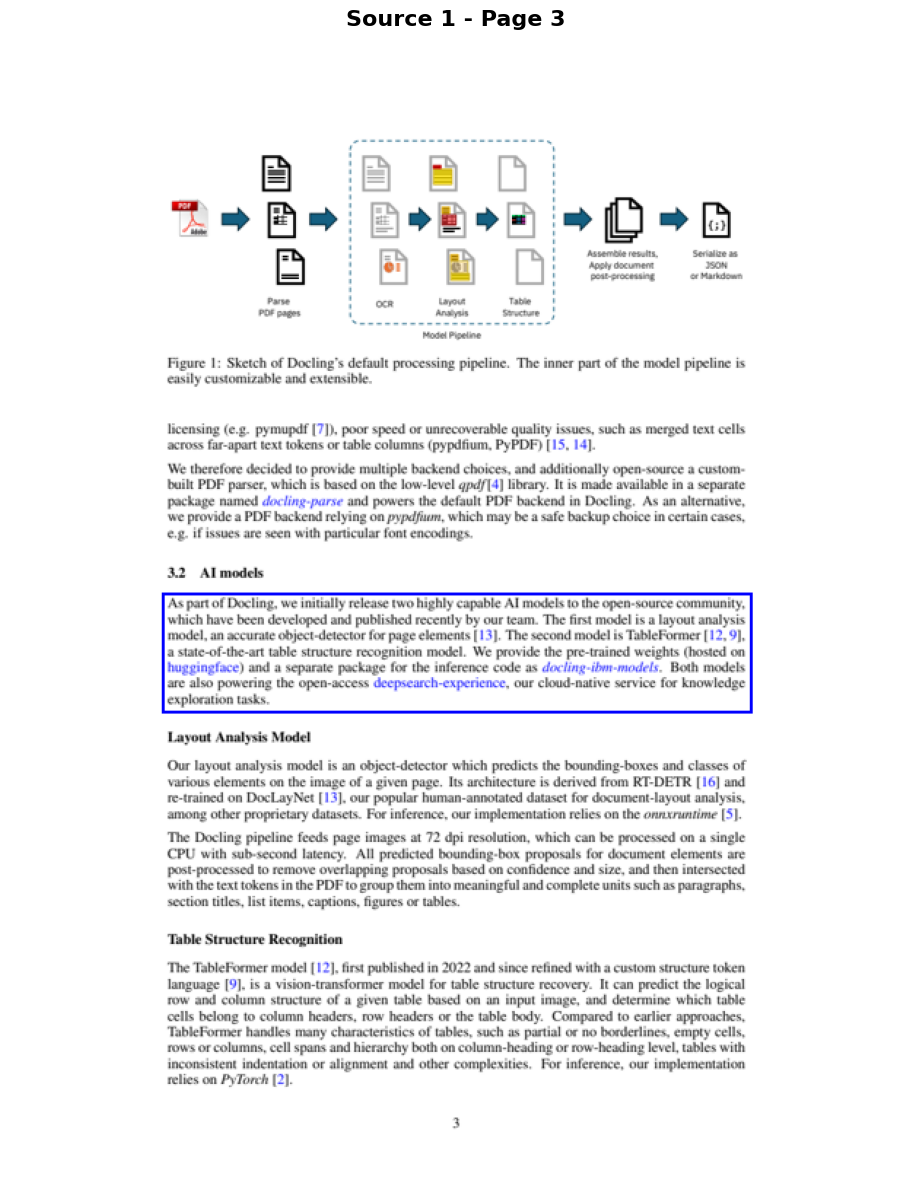


📍 Source 2:
  📝 Text: "As part of Docling, we initially release two highly capable AI models to the open-source community, which have been developed and published recently by our team. The first model is a layout analysis model, an accurate object-detector for page elements [13]. The second model is TableFormer [12, 9], a state-of-the-art table structure recognition mode..."
  📄 Page: 3


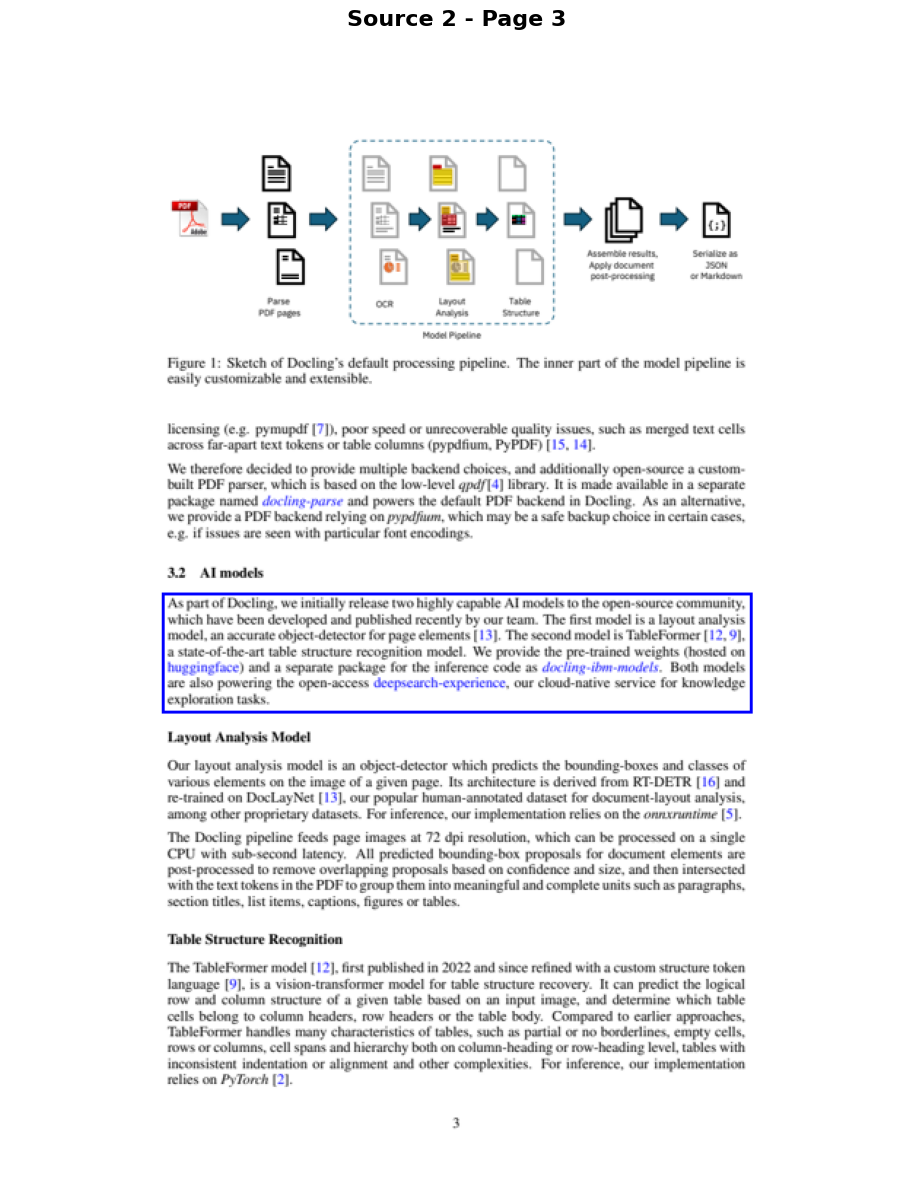

In [17]:
# Visualize grounding for top 3 sources
visualize_grounding(res.source_nodes, client, max_sources=3, pdf_path=pdf_path)

### Print node / chunk details

In [18]:
res.source_nodes = sorted(
    res.source_nodes, key=lambda x: x.score if isinstance(x, NodeWithScore) else 0, reverse=True
)
console.print("\n📚 Source Nodes (sorted by relevance):")
for i, node in enumerate(res.source_nodes):
    score_str = f" (score: {node.score:.4f})" if isinstance(node, NodeWithScore) else ""
    console.print(f"\n--- Source Node {i + 1}{score_str} ---")
    pprint(node.node.to_dict())

📚 Source Nodes (sorted by relevance):

--- Source Node 1 (score: 0.7766) ---

{
│   'id_': 'fdf456e4-79b0-4f5a-b3a1-6c980c17418b',
│   'embedding': None,
│   'metadata': {
│   │   'file_path': 'C:\\Users\\PMACHA~1\\AppData\\Local\\Temp\\tmpjrmp0us8\\2408.09869.pdf',
│   │   'file_name': '2408.09869.pdf',
│   │   'file_type': 'application/pdf',
│   │   'file_size': 5566575,
│   │   'creation_date': '2026-01-16',
│   │   'last_modified_date': '2026-01-16',
│   │   'schema_name': 'docling_core.transforms.chunker.DocMeta',
│   │   'version': '1.0.0',
│   │   'doc_items': [
│   │   │   {
│   │   │   │   'self_ref': '#/texts/50',
│   │   │   │   'parent': {'$ref': '#/body'},
│   │   │   │   'children': [],
│   │   │   │   'content_layer': 'body',
│   │   │   │   'label': 'text',
│   │   │   │   'prov': [
│   │   │   │   │   {
│   │   │   │   │   │   'page_no': 3,
│   │   │   │   │   │   'bbox': {
│   │   │   │   │   │   │   'l': 108.0,
│   │   │   │   │   │   │   't': 404.873,
│   │   │   │   │   │   │   'r': 504.003,
│   │   │   │   │   │   │   'b': 330.866,
│   │   │   │   │   │   │   'coord_origin': 'BOTTOMLEFT'
│   │   │   │   │   │   },
│   │   │   │   │   │   'charspan': [0, 608]
│   │   │   │   │   }
│   │   │   │   ]
│   │   │   }
│   │   ],
│   │   'headings': ['3.2 AI models'],
│   │   'origin': {
│   │   │   'mimetype': 'application/pdf',
│   │   │   'binary_hash': '11465328351749295394',
│   │   │   'filename': '2408.09869.pdf'
│   │   }
│   },
│   'excluded_embed_metadata_keys': [
│   │   'schema_name',
│   │   'version',
│   │   'doc_items',
│   │   'origin',
│   │   'file_name',
│   │   'file_type',
│   │   'file_size',
│   │   'creation_date',
│   │   'last_modified_date',
│   │   'last_accessed_date'
│   ],
│   'excluded_llm_metadata_keys': [
│   │   'schema_name',
│   │   'version',
│   │   'doc_items',
│   │   'origin',
│   │   'file_name',
│   │   'file_type',
│   │   'file_size',
│   │   'creation_date',
│   │   'last_modified_date',
│   │   'last_accessed_date'
│   ],
│   'relationships': {
│   │   '1': {
│   │   │   'node_id': 'af094726-330a-48b8-ad9e-b72b48deedaf',
│   │   │   'node_type': '4',
│   │   │   'metadata': {
│   │   │   │   'file_path': 'C:\\Users\\PMACHA~1\\AppData\\Local\\Temp\\tmpjrmp0us8\\2408.09869.pdf',
│   │   │   │   'file_name': '2408.09869.pdf',
│   │   │   │   'file_type': 'application/pdf',
│   │   │   │   'file_size': 5566575,
│   │   │   │   'creation_date': '2026-01-16',
│   │   │   │   'last_modified_date': '2026-01-16'
│   │   │   },
│   │   │   'hash': 'c55d895feffe444cc57cabe8b57abe26f5ef6c42b105b36f774574a5652e900f',
│   │   │   'class_name': 'RelatedNodeInfo'
│   │   },
│   │   '2': {
│   │   │   'node_id': 'b94a6800-05b5-49d4-b10c-060e8679cad1',
│   │   │   'node_type': '1',
│   │   │   'metadata': {
│   │   │   │   'file_path': 'C:\\Users\\PMACHA~1\\AppData\\Local\\Temp\\tmpjrmp0us8\\2408.09869.pdf',
│   │   │   │   'file_name': '2408.09869.pdf',
│   │   │   │   'file_type': 'application/pdf',
│   │   │   │   'file_size': 5566575,
│   │   │   │   'creation_date': '2026-01-16',
│   │   │   │   'last_modified_date': '2026-01-16',
│   │   │   │   'schema_name': 'docling_core.transforms.chunker.DocMeta',
│   │   │   │   'version': '1.0.0',
│   │   │   │   'doc_items': [
│   │   │   │   │   {
│   │   │   │   │   │   'self_ref': '#/texts/48',
│   │   │   │   │   │   'parent': {'$ref': '#/body'},
│   │   │   │   │   │   'children': [],
│   │   │   │   │   │   'content_layer': 'body',
│   │   │   │   │   │   'label': 'text',
│   │   │   │   │   │   'prov': [
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   'page_no': 3,
│   │   │   │   │   │   │   │   'bbox': {
│   │   │   │   │   │   │   │   │   'l': 108.0,
│   │   │   │   │   │   │   │   │   't': 497.107,
│   │   │   │   │   │   │   │   │   'r': 504.003,
│   │   │   │   │   │   │   │   │   'b': 444.919,
│   │   │   │   │   │   │   │   │   'coord_origin': 'BOTTOMLEFT'
│   │   │   │   │   │   │   │   },
│   │   │   │   │   │   │   │   'charspan': [0, 446]
│   │   │   │   │   │   │   }
│   │   │  

--- Source Node 2 (score: 0.7759) ---

{
│   'id_': 'e8ee003f-33fd-4216-a2d7-37d8f009a76e',
│   'embedding': None,
│   'metadata': {
│   │   'file_path': 'C:\\Users\\PMACHA~1\\AppData\\Local\\Temp\\tmp7pwznk16\\2408.09869.pdf',
│   │   'file_name': '2408.09869.pdf',
│   │   'file_type': 'application/pdf',
│   │   'file_size': 5566575,
│   │   'creation_date': '2026-01-16',
│   │   'last_modified_date': '2026-01-16',
│   │   'schema_name': 'docling_core.transforms.chunker.DocMeta',
│   │   'version': '1.0.0',
│   │   'doc_items': [
│   │   │   {
│   │   │   │   'self_ref': '#/texts/50',
│   │   │   │   'parent': {'$ref': '#/body'},
│   │   │   │   'children': [],
│   │   │   │   'content_layer': 'body',
│   │   │   │   'label': 'text',
│   │   │   │   'prov': [
│   │   │   │   │   {
│   │   │   │   │   │   'page_no': 3,
│   │   │   │   │   │   'bbox': {
│   │   │   │   │   │   │   'l': 108.0,
│   │   │   │   │   │   │   't': 404.873,
│   │   │   │   │   │   │   'r': 504.003,
│   │   │   │   │   │   │   'b': 330.866,
│   │   │   │   │   │   │   'coord_origin': 'BOTTOMLEFT'
│   │   │   │   │   │   },
│   │   │   │   │   │   'charspan': [0, 608]
│   │   │   │   │   }
│   │   │   │   ]
│   │   │   }
│   │   ],
│   │   'headings': ['3.2 AI models'],
│   │   'origin': {
│   │   │   'mimetype': 'application/pdf',
│   │   │   'binary_hash': '11465328351749295394',
│   │   │   'filename': '2408.09869.pdf'
│   │   }
│   },
│   'excluded_embed_metadata_keys': [
│   │   'schema_name',
│   │   'version',
│   │   'doc_items',
│   │   'origin',
│   │   'file_name',
│   │   'file_type',
│   │   'file_size',
│   │   'creation_date',
│   │   'last_modified_date',
│   │   'last_accessed_date'
│   ],
│   'excluded_llm_metadata_keys': [
│   │   'schema_name',
│   │   'version',
│   │   'doc_items',
│   │   'origin',
│   │   'file_name',
│   │   'file_type',
│   │   'file_size',
│   │   'creation_date',
│   │   'last_modified_date',
│   │   'last_accessed_date'
│   ],
│   'relationships': {
│   │   '1': {
│   │   │   'node_id': '7113eb77-5ca1-46c5-a21d-550a7de39bb6',
│   │   │   'node_type': '4',
│   │   │   'metadata': {
│   │   │   │   'file_path': 'C:\\Users\\PMACHA~1\\AppData\\Local\\Temp\\tmp7pwznk16\\2408.09869.pdf',
│   │   │   │   'file_name': '2408.09869.pdf',
│   │   │   │   'file_type': 'application/pdf',
│   │   │   │   'file_size': 5566575,
│   │   │   │   'creation_date': '2026-01-16',
│   │   │   │   'last_modified_date': '2026-01-16'
│   │   │   },
│   │   │   'hash': '2de0163ce247129318f6d6d911a3e126bb1478c2bc164c95af510c17dad4fc4a',
│   │   │   'class_name': 'RelatedNodeInfo'
│   │   },
│   │   '2': {
│   │   │   'node_id': 'b30445b5-2db0-4f45-8c4a-4ec34e66a876',
│   │   │   'node_type': '1',
│   │   │   'metadata': {
│   │   │   │   'file_path': 'C:\\Users\\PMACHA~1\\AppData\\Local\\Temp\\tmp7pwznk16\\2408.09869.pdf',
│   │   │   │   'file_name': '2408.09869.pdf',
│   │   │   │   'file_type': 'application/pdf',
│   │   │   │   'file_size': 5566575,
│   │   │   │   'creation_date': '2026-01-16',
│   │   │   │   'last_modified_date': '2026-01-16',
│   │   │   │   'schema_name': 'docling_core.transforms.chunker.DocMeta',
│   │   │   │   'version': '1.0.0',
│   │   │   │   'doc_items': [
│   │   │   │   │   {
│   │   │   │   │   │   'self_ref': '#/texts/48',
│   │   │   │   │   │   'parent': {'$ref': '#/body'},
│   │   │   │   │   │   'children': [],
│   │   │   │   │   │   'content_layer': 'body',
│   │   │   │   │   │   'label': 'text',
│   │   │   │   │   │   'prov': [
│   │   │   │   │   │   │   {
│   │   │   │   │   │   │   │   'page_no': 3,
│   │   │   │   │   │   │   │   'bbox': {
│   │   │   │   │   │   │   │   │   'l': 108.0,
│   │   │   │   │   │   │   │   │   't': 497.107,
│   │   │   │   │   │   │   │   │   'r': 504.003,
│   │   │   │   │   │   │   │   │   'b': 444.919,
│   │   │   │   │   │   │   │   │   'coord_origin': 'BOTTOMLEFT'
│   │   │   │   │   │   │   │   },
│   │   │   │   │   │   │   │   'charspan': [0, 446]
│   │   │   │   │   │   │   }
│   │   │  

In [19]:
# Display top 3 source chunks
print("\n" + "="*88)
print("📚 TOP 3 SOURCE CHUNKS")
print("="*88 + "\n")

for idx, source_node in enumerate(res.source_nodes[:3], 1):
    print(f"{'─'*88}")
    print(f"📄 CHUNK #{idx} - Relevance Score: {source_node.score:.4f}")
    print(f"{'─'*88}")
    
    # Get metadata
    doc_items = source_node.metadata.get('doc_items', [])
    labels = [item.get('label', 'unknown') for item in doc_items]
    
    # Get page info
    pages = set()
    for item in doc_items:
        for prov in item.get('prov', []):
            if 'page' in prov:
                pages.add(prov['page'])
    
    print(f"📍 Location: Page(s) {sorted(pages) if pages else 'N/A'}")
    print(f"🏷️  Element Types: {', '.join(set(labels))}")
    print(f"\n📝 Text Content:")
    print(f"{source_node.text[:400]}...")
    print(f"\n   [Total: {len(source_node.text)} characters]")
    print()


📚 TOP 3 SOURCE CHUNKS

────────────────────────────────────────────────────────────────────────────────────────
📄 CHUNK #1 - Relevance Score: 0.7766
────────────────────────────────────────────────────────────────────────────────────────
📍 Location: Page(s) N/A
🏷️  Element Types: text

📝 Text Content:
As part of Docling, we initially release two highly capable AI models to the open-source community, which have been developed and published recently by our team. The first model is a layout analysis model, an accurate object-detector for page elements [13]. The second model is TableFormer [12, 9], a state-of-the-art table structure recognition model. We provide the pre-trained weights (hosted on h...

   [Total: 608 characters]

────────────────────────────────────────────────────────────────────────────────────────
📄 CHUNK #2 - Relevance Score: 0.7759
────────────────────────────────────────────────────────────────────────────────────────
📍 Location: Page(s) N/A
🏷️  Element Types: text


---

## 🔍 Advanced Feature 1: Filter-Context Query

Leverage document metadata to filter retrieval by document structure (e.g., only retrieve from tables):

In [20]:
# Create metadata filter to retrieve only from tables
filters = MetadataFilters(
    filters=[MetadataFilter(key="doc_items.label", value="table")]
)

# Create retriever with filter
table_retriever = index.as_retriever(filters=filters, similarity_top_k=3)

# Query
QUERY = "How does pypdfium perform?"
nodes = table_retriever.retrieve(QUERY)

print(f"❓ Query: {QUERY}")
print(f"✅ Retrieved {len(nodes)} chunks from tables\n")

# Display results
for idx, node in enumerate(nodes, 1):
    print(f"{'─'*80}")
    print(f"📊 Chunk #{idx} (Score: {node.score:.4f})")
    print(f"📝 Text: {node.text[:200]}...")
    print(f"🏷️  Labels: {[item['label'] for item in node.metadata['doc_items']]}")

❓ Query: How does pypdfium perform?
✅ Retrieved 3 chunks from tables

────────────────────────────────────────────────────────────────────────────────
📊 Chunk #1 (Score: 0.6940)
📝 Text: backend.Pages/s = 0.60 0.92. Intel(R) Xeon E5-2690, native backend.Mem = 6.16 GB. Intel(R) Xeon E5-2690, pypdfium backend.TTS = 239 s 143 s. Intel(R) Xeon E5-2690, pypdfium backend.Pages/s = 0.94 1.57...
🏷️  Labels: ['table']
────────────────────────────────────────────────────────────────────────────────
📊 Chunk #2 (Score: 0.6897)
📝 Text: backend.Pages/s = 0.60 0.92. Intel(R) Xeon E5-2690, native backend.Mem = 6.16 GB. Intel(R) Xeon E5-2690, pypdfium backend.TTS = 239 s 143 s. Intel(R) Xeon E5-2690, pypdfium backend.Pages/s = 0.94 1.57...
🏷️  Labels: ['table']
────────────────────────────────────────────────────────────────────────────────
📊 Chunk #3 (Score: 0.6166)
📝 Text: Table 1: Runtime characteristics of Docling with the standard model pipeline and settings, on our test dataset of 225 pages, on tw

---

### 🎯 Visual Grounding - Filter-Context Query

Visualize the table sources from the filtered query:

[INFO] 2026-01-16 07:39:39,733 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-16 07:39:39,739 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-16 07:39:39,740 [RapidOCR] main.py:53: Using C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-16 07:39:39,801 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-16 07:39:39,803 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-01-16 07:39:39,804 [RapidOCR


📍 Source 1:
  📝 Text: "backend.Pages/s = 0.60 0.92. Intel(R) Xeon E5-2690, native backend.Mem = 6.16 GB. Intel(R) Xeon E5-2690, pypdfium backend.TTS = 239 s 143 s. Intel(R) Xeon E5-2690, pypdfium backend.Pages/s = 0.94 1.57. Intel(R) Xeon E5-2690, pypdfium backend.Mem = 2.42 GB"
  ✅ Loaded document from PDF with page images
  📄 Page: 5


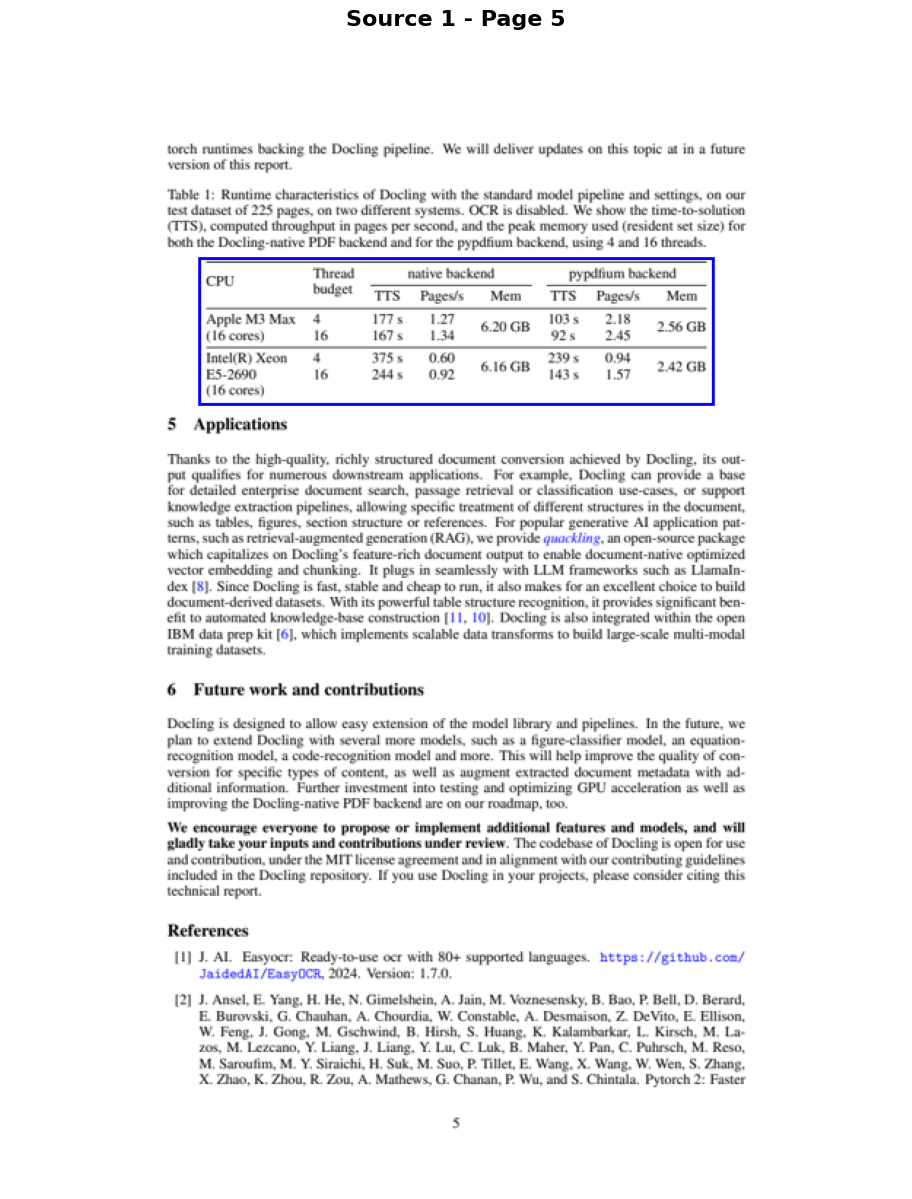


📍 Source 2:
  📝 Text: "backend.Pages/s = 0.60 0.92. Intel(R) Xeon E5-2690, native backend.Mem = 6.16 GB. Intel(R) Xeon E5-2690, pypdfium backend.TTS = 239 s 143 s. Intel(R) Xeon E5-2690, pypdfium backend.Pages/s = 0.94 1.57. Intel(R) Xeon E5-2690, pypdfium backend.Mem = 2.42 GB"
  📄 Page: 5


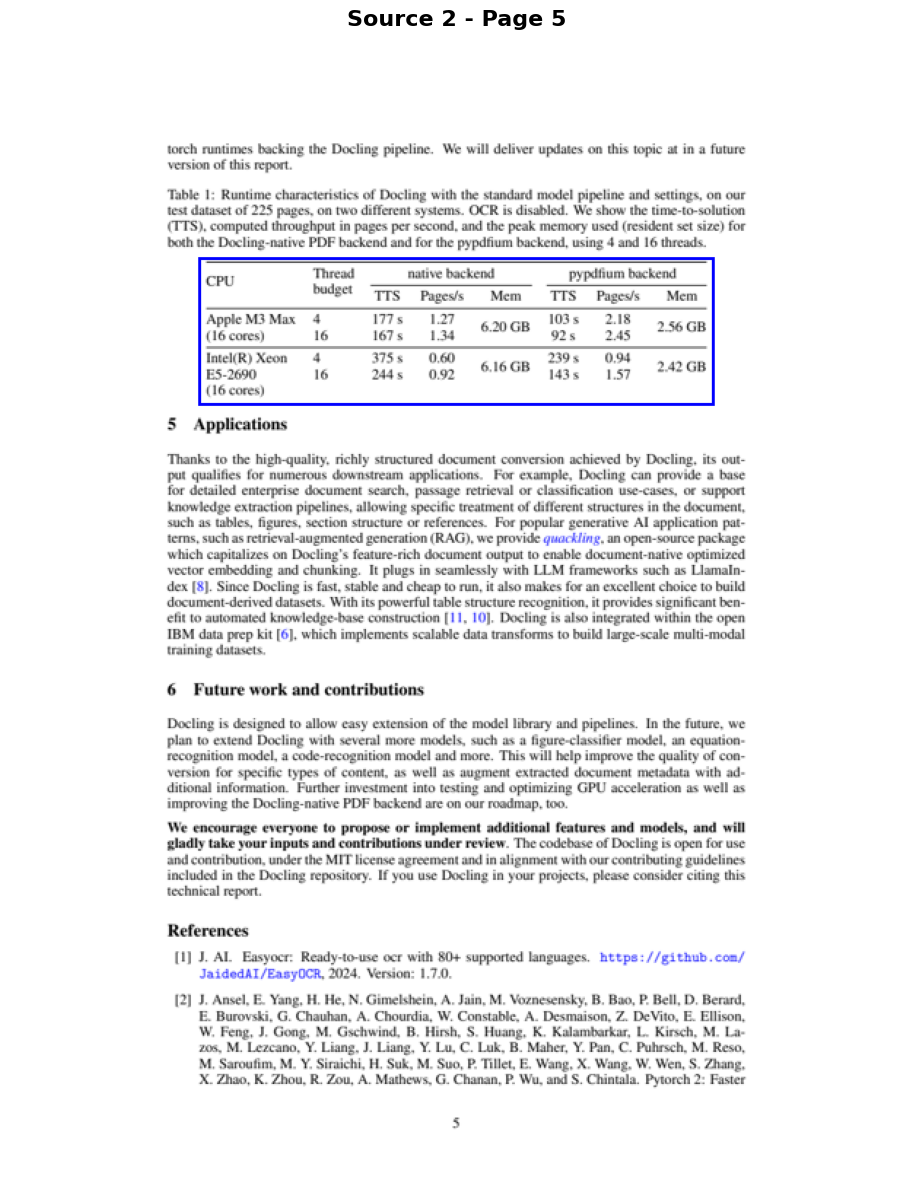


📍 Source 3:
  📝 Text: "Table 1: Runtime characteristics of Docling with the standard model pipeline and settings, on our test dataset of 225 pages, on two different systems. OCR is disabled. We show the time-to-solution (TTS), computed throughput in pages per second, and the peak memory used (resident set size) for both the Docling-native PDF backend and for the pypdfium..."
  📄 Page: 5


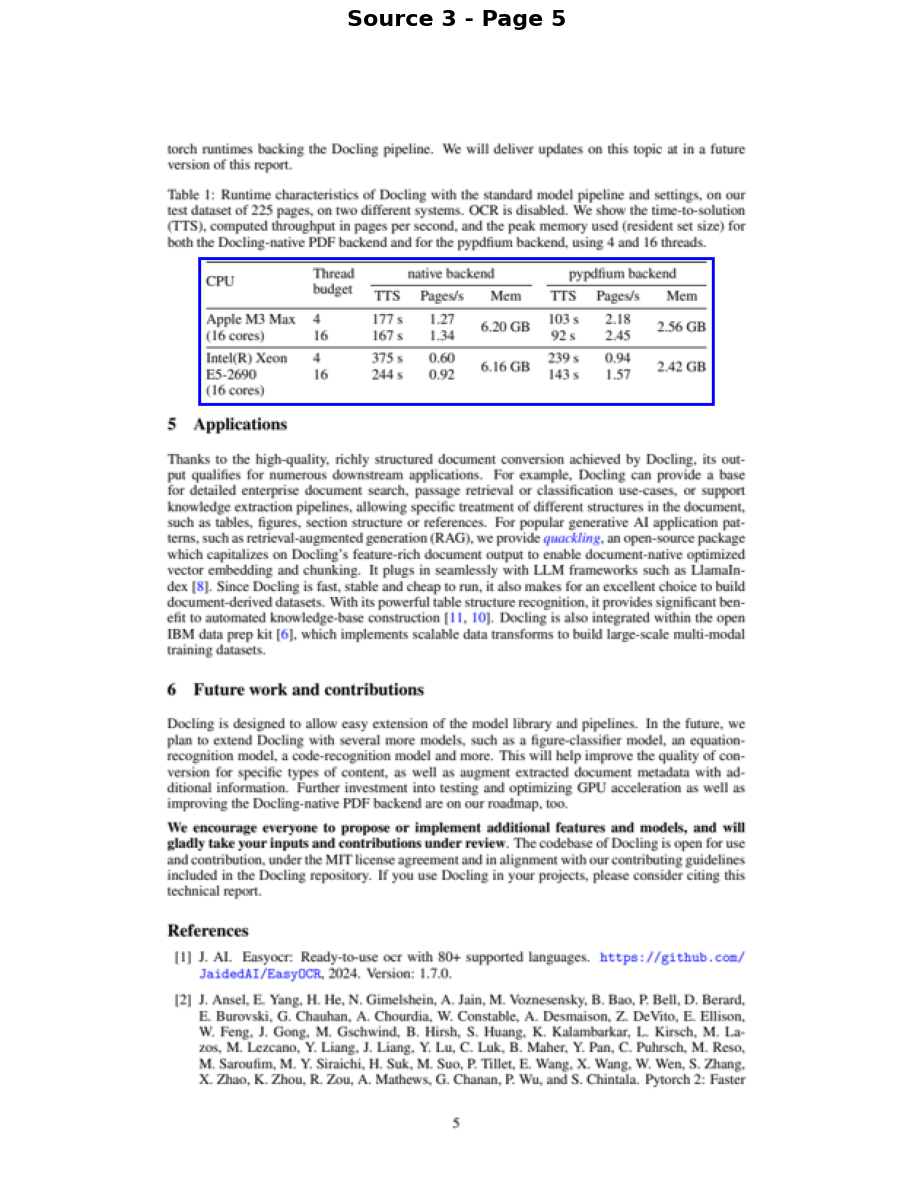

In [22]:
# Visualize table grounding
visualize_grounding(nodes, client, pdf_path=pdf_path)

---

## 🚀 Advanced Feature 2: Hybrid Search with RRF

Combine keyword and vector search using Reciprocal Rank Fusion (RRF):

```mermaid
%%{init: {'theme':'base', 'themeVariables': { 'primaryColor':'#4dabf7','secondaryColor':'#f06595'}}}%%
graph LR
    A["❓ Query"] --> B["🔤 Keyword Search"]
    A --> C["🧮 Vector Search"]
    B --> D["🔀 RRF Fusion"]
    C --> D
    D --> E["📊 Ranked Results"]
    
    style A fill:#74c0fc,stroke:#339af0,stroke-width:3px
    style B fill:#ffa94d,stroke:#fd7e14,stroke-width:2px
    style C fill:#69db7c,stroke:#37b24d,stroke-width:2px
    style D fill:#da77f2,stroke:#9c36b5,stroke-width:3px
    style E fill:#51cf66,stroke:#2f9e44,stroke-width:3px
```

In [23]:
# Create RRF search pipeline
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

url = f"{OPENSEARCH_ENDPOINT}/_search/pipeline/rrf-pipeline"
headers = {"Content-Type": "application/json"}
body = {
    "description": "Post processor for hybrid RRF search",
    "phase_results_processors": [
        {"score-ranker-processor": {"combination": {"technique": "rrf"}}}
    ],
}

response = requests.put(
    url, 
    json=body, 
    headers=headers,
    auth=(OPENSEARCH_USERNAME, OPENSEARCH_PASSWORD),
    verify=False
)
print(f"✅ RRF Pipeline created: {response.json()}")

# Create new index with RRF
client_rrf = OpensearchVectorClient(
    endpoint=OPENSEARCH_ENDPOINT,
    index=f"{OPENSEARCH_INDEX}",
    dim=embed_dim,
    engine="faiss",
    embedding_field=embed_field,
    text_field=text_field,
    search_pipeline="rrf-pipeline",
    http_auth=(OPENSEARCH_USERNAME, OPENSEARCH_PASSWORD),
    use_ssl=True,
    verify_certs=False,
)

vector_store_rrf = OpensearchVectorStore(client_rrf)
storage_context_rrf = StorageContext.from_defaults(vector_store=vector_store_rrf)

# Index with RRF
index_hybrid = VectorStoreIndex.from_documents(
    documents=documents,
    transformations=[node_parser, MetadataTransform()],
    storage_context=storage_context_rrf,
    embed_model=EMBED_MODEL,
)

print("✅ Hybrid search index created with RRF")

✅ RRF Pipeline created: {'acknowledged': True}
✅ Hybrid search index created with RRF


### Test Hybrid Search

Compare vector-only vs hybrid search:

In [24]:
QUERY = "Does Docling project provide a Dockerfile?"

# Vector-only search
retriever = index.as_retriever(similarity_top_k=3)
nodes_vector = retriever.retrieve(QUERY)

# Hybrid search with RRF
retriever_rrf = index_hybrid.as_retriever(
    vector_store_query_mode=VectorStoreQueryMode.HYBRID, 
    similarity_top_k=3
)
nodes_hybrid = retriever_rrf.retrieve(QUERY)

print(f"❓ Query: {QUERY}\n")
print("="*80)
print("🔵 VECTOR-ONLY SEARCH (Top Result):")
print(f"Score: {nodes_vector[0].score:.4f}")
print(f"Text: {nodes_vector[0].text[:200]}...")

print("\n" + "="*80)
print("🔴 HYBRID SEARCH WITH RRF (Top Result):")
print(f"Score: {nodes_hybrid[0].score:.4f}")
print(f"Text: {nodes_hybrid[0].text[:200]}...")

# Check if "Dockerfile" keyword appears
if "Dockerfile" in nodes_hybrid[0].text:
    print("\n✅ Hybrid search found the keyword 'Dockerfile' in top result!")

❓ Query: Does Docling project provide a Dockerfile?

🔵 VECTOR-ONLY SEARCH (Top Result):
Score: 0.6677
Text: Docling is designed to allow easy extension of the model library and pipelines. In the future, we plan to extend Docling with several more models, such as a figure-classifier model, an equationrecogni...

🔴 HYBRID SEARCH WITH RRF (Top Result):
Score: 0.0310
Text: ```
source = "https://arxiv.org/pdf/2206.01062" # PDF path or URL converter = DocumentConverter() result = converter.convert_single(source) print(result.render_as_markdown()) # output: "## DocLayNet: ...

✅ Hybrid search found the keyword 'Dockerfile' in top result!


---

### 🎯 Visual Grounding - Hybrid Search

Compare visual grounding between vector-only and hybrid search results:

#### 🔵 Vector-Only Search Grounding

[INFO] 2026-01-16 07:40:34,789 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-16 07:40:34,789 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-16 07:40:34,789 [RapidOCR] main.py:53: Using C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-16 07:40:34,868 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-16 07:40:34,870 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-01-16 07:40:34,870 [RapidOCR


📍 Source 1:
  📝 Text: "Docling is designed to allow easy extension of the model library and pipelines. In the future, we plan to extend Docling with several more models, such as a figure-classifier model, an equationrecognition model, a code-recognition model and more. This will help improve the quality of conversion for specific types of content, as well as augment extr..."
  ✅ Loaded document from PDF with page images
  📄 Page: 5


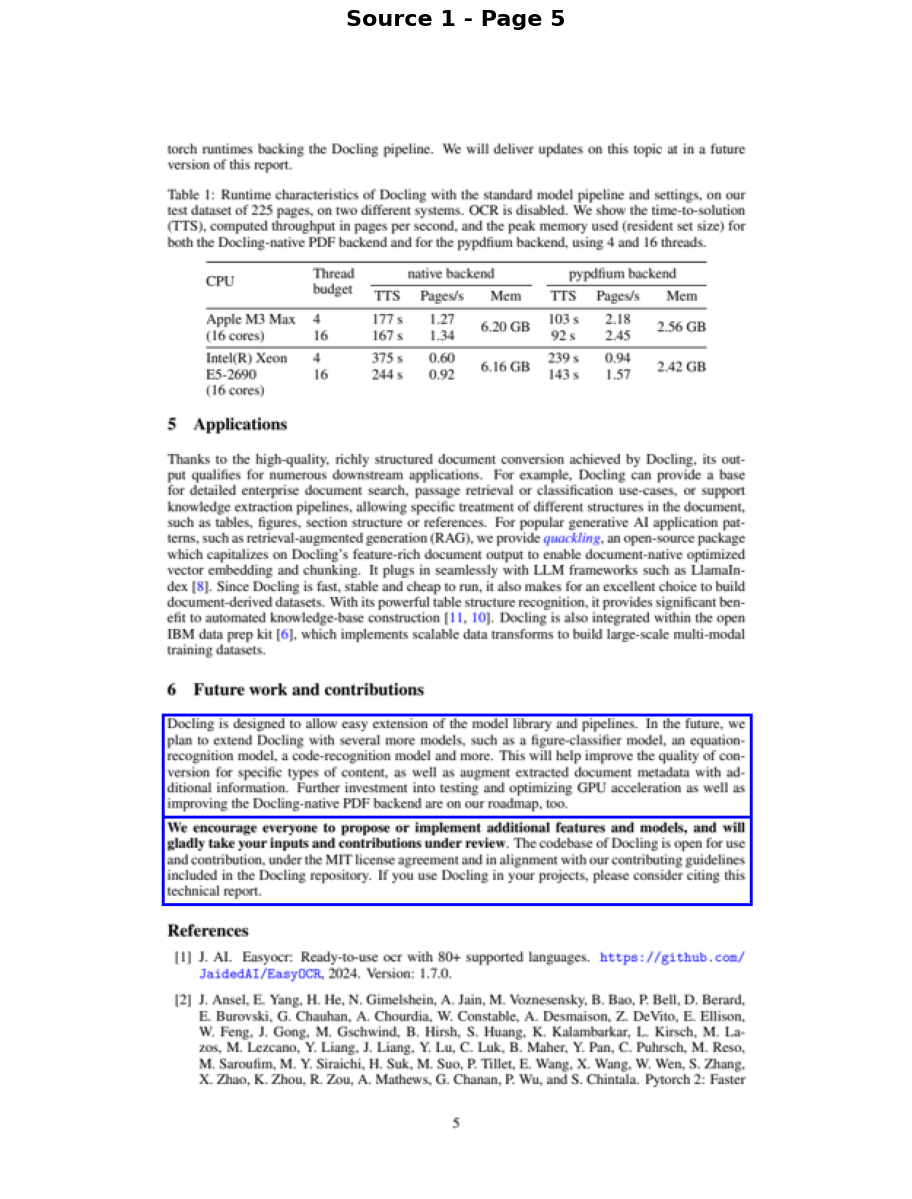

In [25]:
visualize_grounding(nodes_vector, client, pdf_path=pdf_path, max_sources=1)

#### 🔴 Hybrid Search (RRF) Grounding

[INFO] 2026-01-16 07:41:23,143 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-16 07:41:23,146 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-16 07:41:23,146 [RapidOCR] main.py:53: Using C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-16 07:41:23,243 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-16 07:41:23,243 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-01-16 07:41:23,243 [RapidOCR


📍 Source 1:
  📝 Text: "```\nsource = \"https://arxiv.org/pdf/2206.01062\" # PDF path or URL converter = DocumentConverter() result = converter.convert_single(source) print(result.render_as_markdown()) # output: \"## DocLayNet: A Large Human -Annotated Dataset for Document -Layout Analysis [...]\"\n```\nOptionally, you can configure custom pipeline features and runtime options, ..."


[INFO] 2026-01-16 07:41:23,303 [RapidOCR] download_file.py:60: File exists and is valid: C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_rec_infer.onnx
[INFO] 2026-01-16 07:41:23,304 [RapidOCR] main.py:53: Using C:\git-projects\personal\github.com\OPENSEARCH_INTERMEDIATE_TUTORIAL\7. BONUS_PROJECTS\chonkie_docling_langxtract\.venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_rec_infer.onnx


  ✅ Loaded document from PDF with page images
  📄 Page: 2


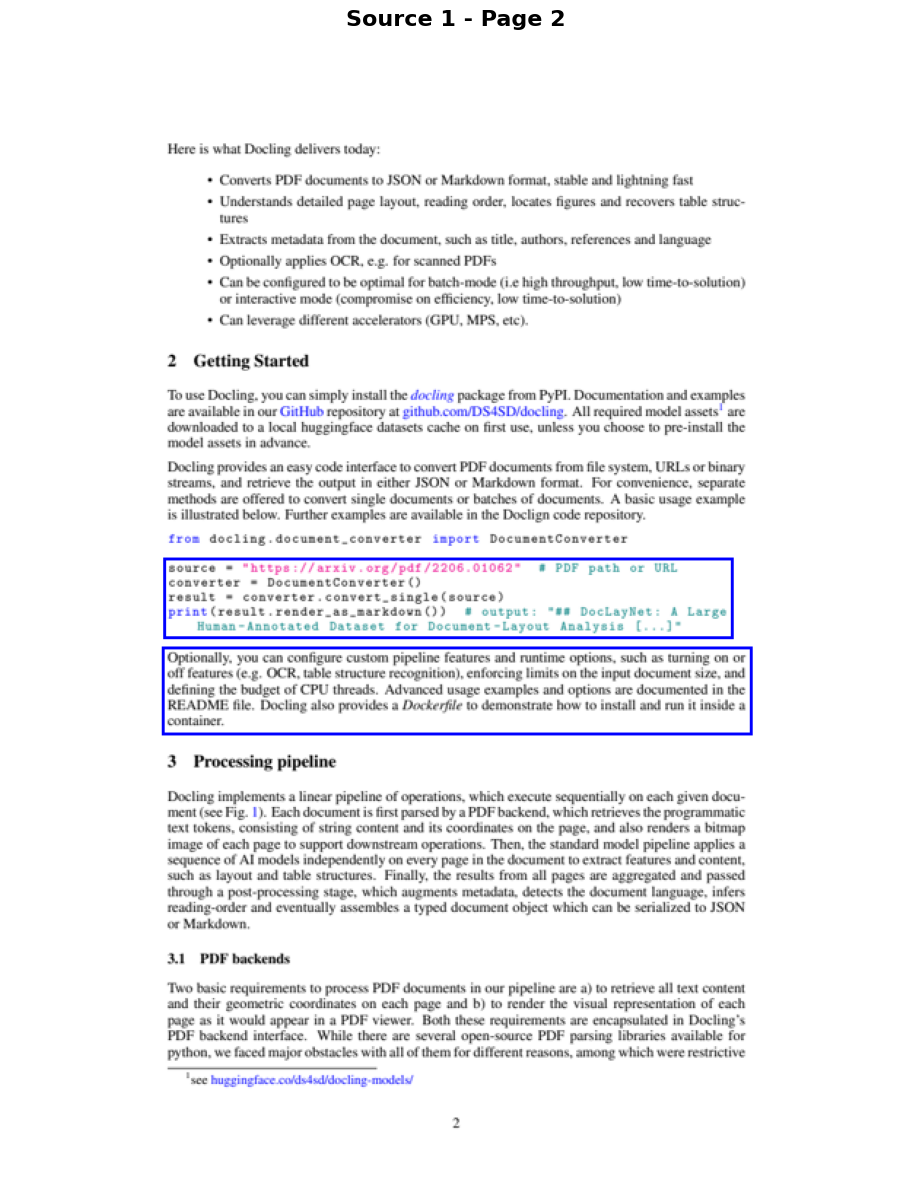

In [26]:
visualize_grounding(nodes_hybrid, client, pdf_path=pdf_path, max_sources=1)

---

## 📚 Summary & Key Takeaways

### What We Built:

1. ✅ **OpenSearch RAG Pipeline** with Docker Compose
2. ✅ **Docling Document Processing** with intelligent PDF parsing
3. ✅ **HybridChunker** for structure-aware chunking
4. ✅ **Local Embeddings** with IBM Granite (no API calls)
5. ✅ **Local LLM** with Ollama Granite (privacy-focused)
6. ✅ **Metadata Filtering** for precise retrieval
7. ✅ **Hybrid Search with RRF** combining keyword + vector search

### Key Concepts:

**DoclingReader**: Converts PDF to structured DoclingDocument
- Preserves headings, tables, figures, and layout
- Exports as JSON to maintain document hierarchy

**HybridChunker**: Intelligent chunking algorithm
- Respects document structure (doesn't split mid-sentence)
- Token-aware (ensures chunks fit embedding model)
- Preserves metadata at chunk level

**OpensearchVectorStore**: Vector database for RAG
- FAISS engine for fast similarity search
- Metadata filtering for advanced retrieval
- Hybrid search with RRF support

**LlamaIndex**: RAG framework orchestration
- Clean abstractions for retrieval and generation
- Flexible query engines and retrievers
- Easy integration with various vector stores

### Production Considerations:

- **Security**: Enable SSL and authentication for OpenSearch
- **Scaling**: Use OpenSearch clusters for high availability
- **Performance**: Tune FAISS parameters and shard configuration
- **Monitoring**: Track query latency and retrieval quality
- **Hybrid Search**: Use RRF for better keyword matching
- **Context Expansion**: Add neighboring chunks for richer context

---

🎉 **Congratulations!** You now have a fully local, privacy-focused RAG system with OpenSearch!